### Import Libraries

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Define paths
root_dir = 'ASL_Dataset'
train_dir = os.path.join(root_dir, 'train')
validation_dir = os.path.join(root_dir, 'validation')
test_dir = os.path.join(root_dir, 'test')


### Data Generator To Refine Images 

In [2]:
# Define image data generators with data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

### Dataset in 3 Parts

In [3]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for accurate evaluation
)

Found 21000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.
Found 6000 images belonging to 10 classes.


### CNN Model

In [4]:
# Define the CNN model with dropout
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\Faez Tassawar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,275,722 (4.87 MB)

 Trainable params: 1,275,722 (4.87 MB)

 Non-trainable params: 0 (0.00 B)

### Training Model

In [9]:
from keras.callbacks import EarlyStopping
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10,
    callbacks=[early_stopping]
)

# Save the model
model.save('gesture_recognition_model.keras')

Epoch 1/10


c:\Users\Faez Tassawar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


636/656 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.2142 - loss: 2.2046

### Accuracy

In [ ]:
# Evaluate on training data
train_loss, train_acc = model.evaluate(train_generator)
print(f'Training accuracy: {train_acc * 100:.2f} %\n')

# Evaluate on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation accuracy: {val_acc * 100:.2f} %\n')

657/657 ━━━━━━━━━━━━━━━━━━━━ 73s 111ms/step - accuracy: 0.9645 - loss: 0.3912
Training accuracy: 96.37 %

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9836 - loss: 0.3218
Validation accuracy: 98.63 %



### Testing Model

In [ ]:
# Perform predictions on the test set
test_generator.reset()
predictions = model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
true_classes = true_classes[:len(predicted_classes)]  # Ensure true_classes matches the length of predicted_classes

# Compute accuracy
accuracy = np.sum(predicted_classes == true_classes) / len(true_classes)
print(f'Computed Test Accuracy: {accuracy * 100:.2f} %')

# Optionally, print a classification report

print('Classification Report')
print(classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys()))

print('Confusion Matrix')
print(confusion_matrix(true_classes, predicted_classes))

188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step
Computed Test Accuracy: 98.90 %
Classification Report
              precision    recall  f1-score   support

           3       0.92      1.00      0.96       600
     Awesome       1.00      1.00      1.00       600
       Hello       0.99      1.00      1.00       600
          No       1.00      1.00      1.00       600
     Promise       1.00      0.99      0.99       600
 Right There       1.00      0.99      1.00       600
        Stop       1.00      1.00      1.00       600
   Thank You       1.00      1.00      1.00       600
     Victory       0.99      0.91      0.95       600
         Yes       1.00      1.00      1.00       600

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000

Confusion Matrix
[[600   0   0   0   0   0   0   0   0   0]
 [  0 600   0   0   0   0   0   0   0   0]
 [  0   0 600   0   0   0   0   0   0   0

### Print Assign Class Indexes

In [5]:
model = load_model("gesture_recognition_model.keras")

class_indices = train_generator.class_indices
print("Class Indices:", class_indices)

classes = list(class_indices.keys())
indexes = list(class_indices.values())

print("\nClasses:", classes)
print("\nIndexes:", indexes)

Class Indices: {'3': 0, 'Awesome': 1, 'Hello': 2, 'No': 3, 'Promise': 4, 'Right There': 5, 'Stop': 6, 'Thank You': 7, 'Victory': 8, 'Yes': 9}

Classes: ['3', 'Awesome', 'Hello', 'No', 'Promise', 'Right There', 'Stop', 'Thank You', 'Victory', 'Yes']

Indexes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### Unseen Image

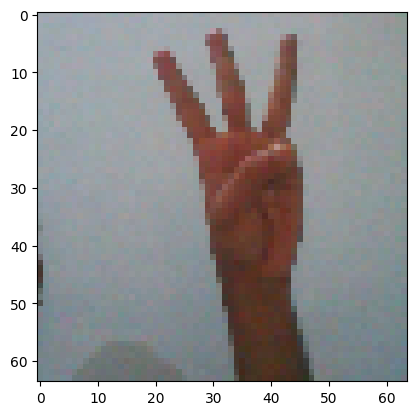

In [6]:
image = load_img("./ASL_Dataset/test/3/5.jpg",target_size=(64, 64))
input_array = img_to_array(image)/255 # To normalize divide by 255

plt.imshow(input_array)
plt.show()

input_array = np.expand_dims(input_array,axis=0)

### Prediction

In [7]:
prediction = model.predict(input_array)
class_index = np.argmax(prediction, axis=1)[0]
print("\nProbabilities:", prediction)
print("\nGesture Class Index:", class_index)

predicted_class = classes[indexes.index(class_index)]

print("\nPredicted Gesture:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step

Probabilities: [[9.9908900e-01 4.8611901e-09 7.9030595e-22 3.8843737e-07 9.3705336e-19
  1.1631204e-11 2.5842517e-16 8.2644863e-11 9.0280263e-04 7.8200756e-06]]

Gesture Class Index: 0

Predicted Gesture: 3


### More Prediction

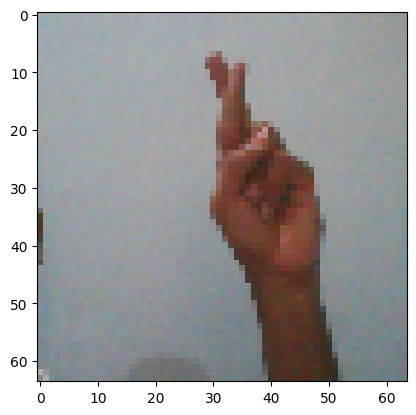

In [8]:
image = load_img("./ASL_Dataset/test/Promise/5.jpg",target_size=(64, 64))
input_array = img_to_array(image)/255 # To normalize divide by 255

plt.imshow(input_array)
plt.show()

input_array = np.expand_dims(input_array,axis=0)

In [9]:
prediction = model.predict(input_array)
class_index = np.argmax(prediction, axis=1)[0]
print("\nProbabilities:", prediction)
print("\nGesture Class Index:", class_index)

predicted_class = classes[indexes.index(class_index)]

print("\nPredicted Gesture:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Probabilities: [[5.7211313e-08 4.0324576e-08 3.5432720e-05 3.5390705e-05 9.8631150e-01
  1.1733419e-08 3.7642110e-07 5.7197278e-03 7.8921430e-03 5.3067611e-06]]

Gesture Class Index: 4

Predicted Gesture: Promise
